## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os 

# Datasets and functions
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Pré-modèles
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
# -------------------------------------------
# TRANSFORMATION DATAFRAME

# Transformation de la valeur en texte
def text_type_select(value, feature, select=0) :
    """ Retourne un type de texte selon la sélection
    0. <value> <feature>
    1. <value> <unit> of <name> (avec feature = (<name>, <unit>))

    Args:
        - `value` (float): la valeur du feature
        - `feature` (str): le nom de feature
        - `select` (int, optional): Type de texte à sélectionner. Defaults to 0.

    Returns:
        str: Texte retourné
    """
    if select == 0 :
        return str(value) + " " + str(feature)
    if select == 1 :
        name, unit = feature
        return str(value) + " " + str(unit) + " of " + str(name)
    
# Transformation d'une ligne en texte
def df_row_to_text(Xi:pd.DataFrame, yi:pd.DataFrame, feature_names, subject_name = "subject", has_unit=False) :
    """ Pour une ligne d'un DataFrame, génère un texte expliquant la ligne

    Args:
        - `Xi` (pd.DataFrame): Un exemple de features
        - `yi` (pd.DataFrame): Un label
        - `feature_names` (List[str]): une liste de colonnes
        - `subject_name` (str, optional): Le nom du sujet pour l'affichage. Defaults to "subject".
        - `has_unit` (bool, optional): _description_. Defaults to True.

    Returns:
        str: Le texte généré
    """

    # features name - unit
    if has_unit :
        try :
            regex_unit_pattern = r'([\w ]+)\s+\((\w+)\)$'
            feature_names = [re.search(regex_unit_pattern, feature).groups() for feature in feature_names] 
            has_unit_vector = [True if len(tuple) == 2 else False for tuple in feature_names]
        except :
            has_unit_vector = [False for _ in feature_names]
    else :
        has_unit_vector = [False for _ in feature_names]

    # generate text type
    value_feature_text_list = [text_type_select(value, feature, select=1) if has_unit_vector[i] \
                               else text_type_select(value, feature, select=0) \
                               for i, (value, feature) in enumerate(zip(Xi, feature_names))]

    # generate text
    text = "The " + subject_name + " with "
    for vf in value_feature_text_list[:-1] :
        text += vf + ", "
    text = text[:-2]
    text += " and " + value_feature_text_list[-1]
    text += " is " + str(yi) # a / an 

    return text

# Liste de textes
def df_texts_list(X:pd.DataFrame, y:pd.DataFrame, **kwargs) :
    """ Génère la liste de textes à partir des features X et des labels y

    Args:
        - `X` (pd.DataFrame): features
        - `y` (pd.DataFrame): labels
        - `subject_name` (str, optional): _description_. Defaults to "subject".
        - `has_unit` (bool, optional): _description_. Defaults to False.

    Returns:
        List[str]: une liste de textes des lignes du dataset
    """
    return [df_row_to_text(X.iloc[i], y.iloc[i], X.columns, **kwargs) for i in range(len(X))]

# DataFrame Texte (Main)
def data_to_df_text(data, target=None, feature_names=None, target_names=None, **kwargs) :
    """ 

    Args:
        - `data` (Dict | pd.DataFrame): Si `target` n'est pas spécifié, alors un dictionnaire contenant
        'data', 'target', 'feature_names' et 'target_names', sinon un DataFrame de features
        - `target` (pd.DataFrame, optional): Un DataFrame de labels. Defaults to None.
        - `feature_names` (List[str], optional): Une liste de noms de features. Defaults to None.
        - `target_names` (List[str], optional): Une liste de noms de labels. Defaults to None.

    Returns:
        pd.Series: liste de textes transformés en pd.Series
    """
    if target is None :
        if 'feature_names' in data :
            X = pd.DataFrame(data['data'], columns=data['feature_names'])
        else :
            X = pd.DataFrame(data['data'])
        y = pd.Series(data['target'])
        if 'target_names' in data :
            y = y.map({i:label for i, label in enumerate(data['target_names'])})
    else :
        if feature_names is not None :
            X = pd.DataFrame(data, columns=feature_names)
        else :
            X = pd.DataFrame(data)
        y = pd.Series(target)
        if target_names is not None :
            y = y.map({i:label for i, label in enumerate(target_names)})
    return pd.Series(df_texts_list(X, y, **kwargs))

# DataFrame Display (Main)
def display_df(df:pd.DataFrame) :
    """ Permet de voir le DataFrame en entier

    Args:
        - `df` (pd.DataFrame): Le DataFrame à afficher
    """
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    print(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

# -------------------------------------------
# TRAINING

# Training (Main) à améliorer (comme ajouter des métriques)
def train_clf(clf, X_train, y_train) :
    """_summary_

    Args:
        - `clf` (_type_): classifieur à entraîner
        - `X_train` (pd.DataFrame): features
        - `y_train` (pd.DataFrame): labels
    """
    clf.fit(X_train, y_train) 
    print(clf.predict(X_train))

# -------------------------------------------
# TRAITEMENT

# Récupérer la liste de features et le nom de label de la question
def question_to_list(q) :
    """ Décompose la question en liste de features et détecte le nom type de label

    Args:
        - `q` (str): La question sous le format : "When we have <feature_1>=<value_1>, 
        <feature_2>=<value_2>, ..., <feature_n>=<value_n>, what should be the <label_type_name> ?"

    Returns:
        List[str], str: une liste de features et un nom type de label
    """
    pattern = r'be (.*) \?'
    match = re.search(pattern, q)
    a_label = match.group(1)

    pattern = r'have (.*), what'
    match = re.search(pattern, q.strip())
    a_features = match.group(1)
    a_list_features = a_features.split(',')
    a_list_features = [feature.strip() for feature in a_list_features]

    return a_list_features, a_label


# Transformation d'une ligne de Dataset en question (pour pouvoir tester et vérifier)
def df_row_to_question(X:pd.DataFrame, feature_names, subject="subject") :
    # Question --> When we have sepal length (cm)=0.3, sepal width (cm)=0.4, petal length (cm)=0.1, petal width (cm)=0.2, what should be the iris type ?
    # Réponse --> When we have sepal length (cm)=0.3, sepal width (cm)=0.4, petal length (cm)=0.1, petal width (cm)=0.2, the iris type is setosa

    list_res = []
    for index, row in X.iterrows() :
        res = "When we have "
        # print("----------------")
        for feature, value in zip(feature_names, row) :
            # print(feature, ":", value)
            res += feature + "=" + str(value) + ", "
        res += "what should be the " + subject + " ?"
        list_res.append(res)
    return list_res

# Transformer en DataFrame pour faire passer dans le calcul de prédiction
def question_to_df(q) :
    """ Transforme la question en DataFrame permettant de mieux analyser (faire passer en predict d'un classifieur)

    Args:
        - `q` (str): La question sous le format : "When we have <feature_1>=<value_1>, 
        <feature_2>=<value_2>, ..., <feature_n>=<value_n>, what should be the <label_type_name> ?"

    Returns:
        pd.DataFrame: un DataFrame correspondant à la question
    """
    a_list_features, _ = question_to_list(q)
    a_list_features_split = [feature.split('=') for feature in a_list_features]
    a_features_names = [feature[0] for feature in a_list_features_split]
    try : 
        a_features_values = [float(feature[1]) for feature in a_list_features_split]
    except :
        a_features_values = [feature[1] for feature in a_list_features_split]
    return pd.DataFrame(data=np.array([a_features_values]), columns=a_features_names)

# Prédiction de la réponse
def q_df_to_answer(clf, df) :
    """ Prédit le label grâce au DataFrame généré par la question

    Args:
        - `clf` (_type_): un classifieur
        - `df` (pd.DataFrame): un DataFrame

    Returns:
        str: le label prédit
    """
    return clf.predict(df)[0]

# Format de q et a en texte
def answer_to_text(q, a) :
    """ Permet de rendre les questions et le label réponse dans un format qui donne la réponse

    Args:
        - `q` (str): question
        - `a` (str): label réponse

    Returns:
        str: le format de la réponse que le modèle doit donner
    """
    _, a_label = question_to_list(q)
    pattern = r'what .* \?'
    qa = re.sub(pattern, '', q.strip())
    return qa.strip() + " " + a_label + " is " + str(a)

# Réponse du programme à partir de la question
def traitement_question(clf, q) :
    """ Traitement de la question `q` qui utilise un classifieur `clf` pour générer une réponse

    Args:
        - `clf` (_type_): classifieur
        - `q` (str): question

    Returns:
        str: la réponse à la question `q`
    """
    q_df = question_to_df(q)
    a = q_df_to_answer(clf, q_df)
    return answer_to_text(q, a)

In [3]:
# Fine-tuning du modèle
def train_premodel(model_name="gpt2", dataset_path="./iris_dataset.txt", save_path="./fine-tuned-gpt2") :
    """ Permet de fine-tuner un modèle pré-entraîné de hugging face, ici c'est plus spécifiquement GPT-2

    Args:
        - `model_name` (str, optional): le nom du modèle de hugging face. Defaults to "gpt2".
        - `dataset_path` (str, optional): le chemin d'accès du dataset. Defaults to "./iris_dataset.txt".
        - `save_path` (str, optional): le chemin d'accès pour sauvegarder le modèle fine-tuné. Defaults to "./fine-tuned-gpt2".
    """

    # Load pre-trained GPT-2 model and tokenizer
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    dataset = TextDataset(tokenizer=tokenizer, file_path=dataset_path, block_size=128)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=save_path,
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        save_steps=10_000,
        save_total_limit=2,
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=dataset,
    )

    trainer.train()
    model.save_pretrained(save_path)

# Récupérer le model et le tokenizer
def get_model_tokenizer(model_path="./fine-tuned-gpt2", tokenizer_path="gpt2") :
    """ Récupérer le modèle et le tokenizer

    Args:
        - `model_path` (str, optional): le chemin d'accès du modèle fine-tuné. Defaults to "./fine-tuned-gpt2".
        - `tokenizer_path` (str, optional): le chemin d'accès du tokenizer. Defaults to "gpt2".

    Returns:
        _type_: le model et le tokenizer
    """
    # Load fine-tuned GPT-2 model and tokenizer
    model_path = model_path
    tokenizer_path = tokenizer_path
    model = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True)
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return model, tokenizer

# Tester le modèle
def test_premodel(model, tokenizer, prompt="The flower with", max_length=100, temperature=1, top_k=1) :
    """ Teste le modèle fine-tuné

    Args:
        - `model` (_type_): le modèle
        - `tokenizer` (_type_): le tokenizer
        - `prompt` (str, optional): le prompt avec lequel le modèle va générer un texte. Defaults to "The flower with".
        - `max_length` (int, optional): longueur maximale de la réponse. Defaults to 100.
        - `temperature` (int, optional): température de la réponse. Defaults to 1.
        - `top_k` (int, optional): le top k de la réponse. Defaults to 1.
    """

    # Generate text samples
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=temperature, top_k=top_k) # top_k=50

    # Decode generated output
    generated_texts = tokenizer.batch_decode(output, skip_special_tokens=True)

    # Print generated texts
    for i, text in enumerate(generated_texts):
        print(f"Generated Text {i+1}: {text}")

## 1. Préparation du Dataset

In [4]:
# 1. Chargement du Dataset Iris

iris = datasets.load_iris()
print([key for key in iris])
print(iris['feature_names'])
print(iris['target_names'])

X = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y = pd.Series(iris['target']).map({i:label for i, label in enumerate(iris['target_names'])})

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [5]:
X['petal length (cm)'].describe()

count    150.000000
mean       3.758000
std        1.765298
min        1.000000
25%        1.600000
50%        4.350000
75%        5.100000
max        6.900000
Name: petal length (cm), dtype: float64

In [6]:
display_df(X.iloc[99:].head())
display_df(y.iloc[99:].head())

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
99                 5.7               2.8                4.1               1.3
100                6.3               3.3                6.0               2.5
101                5.8               2.7                5.1               1.9
102                7.1               3.0                5.9               2.1
103                6.3               2.9                5.6               1.8
99     versicolor
100     virginica
101     virginica
102     virginica
103     virginica
dtype: object


In [7]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [8]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=40)

for text in df_texts_list(X_test, y_test, subject_name="iris specie", has_unit=True) :
    print(text)

The iris specie with 4.4 cm of sepal length, 3.0 cm of sepal width, 1.3 cm of petal length and 0.2 cm of petal width is setosa
The iris specie with 5.6 cm of sepal length, 3.0 cm of sepal width, 4.5 cm of petal length and 1.5 cm of petal width is versicolor
The iris specie with 6.4 cm of sepal length, 3.2 cm of sepal width, 5.3 cm of petal length and 2.3 cm of petal width is virginica
The iris specie with 7.7 cm of sepal length, 3.8 cm of sepal width, 6.7 cm of petal length and 2.2 cm of petal width is virginica
The iris specie with 5.5 cm of sepal length, 2.5 cm of sepal width, 4.0 cm of petal length and 1.3 cm of petal width is versicolor
The iris specie with 6.3 cm of sepal length, 3.4 cm of sepal width, 5.6 cm of petal length and 2.4 cm of petal width is virginica
The iris specie with 6.2 cm of sepal length, 2.2 cm of sepal width, 4.5 cm of petal length and 1.5 cm of petal width is versicolor
The iris specie with 5.6 cm of sepal length, 2.7 cm of sepal width, 4.2 cm of petal length

In [9]:
for text in df_texts_list(X_train, y_train, subject_name="iris specie", has_unit=True) :
    print(text)

The iris specie with 6.0 cm of sepal length, 2.2 cm of sepal width, 4.0 cm of petal length and 1.0 cm of petal width is versicolor
The iris specie with 5.1 cm of sepal length, 3.3 cm of sepal width, 1.7 cm of petal length and 0.5 cm of petal width is setosa
The iris specie with 5.0 cm of sepal length, 3.4 cm of sepal width, 1.6 cm of petal length and 0.4 cm of petal width is setosa
The iris specie with 5.3 cm of sepal length, 3.7 cm of sepal width, 1.5 cm of petal length and 0.2 cm of petal width is setosa
The iris specie with 4.7 cm of sepal length, 3.2 cm of sepal width, 1.3 cm of petal length and 0.2 cm of petal width is setosa
The iris specie with 6.4 cm of sepal length, 2.8 cm of sepal width, 5.6 cm of petal length and 2.1 cm of petal width is virginica
The iris specie with 4.6 cm of sepal length, 3.4 cm of sepal width, 1.4 cm of petal length and 0.3 cm of petal width is setosa
The iris specie with 4.4 cm of sepal length, 3.2 cm of sepal width, 1.3 cm of petal length and 0.2 cm of

In [10]:
display_df(pd.DataFrame(df_texts_list(X_test, y_test, subject_name="iris specie", has_unit=True)).sample(n=10, random_state=40))

                                                                                                                                     0
2    The iris specie with 6.4 cm of sepal length, 3.2 cm of sepal width, 5.3 cm of petal length and 2.3 cm of petal width is virginica
16   The iris specie with 6.3 cm of sepal length, 2.7 cm of sepal width, 4.9 cm of petal length and 1.8 cm of petal width is virginica
19  The iris specie with 5.2 cm of sepal length, 2.7 cm of sepal width, 3.9 cm of petal length and 1.4 cm of petal width is versicolor
14  The iris specie with 5.7 cm of sepal length, 2.6 cm of sepal width, 3.5 cm of petal length and 1.0 cm of petal width is versicolor
15   The iris specie with 6.7 cm of sepal length, 3.3 cm of sepal width, 5.7 cm of petal length and 2.5 cm of petal width is virginica
13   The iris specie with 6.2 cm of sepal length, 2.8 cm of sepal width, 4.8 cm of petal length and 1.8 cm of petal width is virginica
20   The iris specie with 6.4 cm of sepal length, 2.8 c

In [11]:
y_test.sample(n=10, random_state=40)

115     virginica
123     virginica
59     versicolor
79     versicolor
144     virginica
126     virginica
132     virginica
117     virginica
81     versicolor
105     virginica
dtype: object

## 2. Fabrication du Dataset de textes

In [12]:
# 2.1. Transformation d'une ligne

row = 145
print(df_row_to_text(iris['data'][row], iris['target'][row], iris['feature_names'], subject_name="flower", has_unit=False))
print(df_row_to_text(iris['data'][row], iris['target'][row], iris['feature_names'], subject_name="flower", has_unit=True))

The flower with 6.7 sepal length (cm), 3.0 sepal width (cm), 5.2 petal length (cm) and 2.3 petal width (cm) is 2
The flower with 6.7 cm of sepal length, 3.0 cm of sepal width, 5.2 cm of petal length and 2.3 cm of petal width is 2


In [13]:
# 2.2. Conversion des samples en texte

iris_text_list = df_texts_list(X, y, subject_name="flower type", has_unit=True)

for text in iris_text_list[:5] + iris_text_list[50:55] + iris_text_list[-5:] :
    print(text)

The flower type with 5.1 cm of sepal length, 3.5 cm of sepal width, 1.4 cm of petal length and 0.2 cm of petal width is setosa
The flower type with 4.9 cm of sepal length, 3.0 cm of sepal width, 1.4 cm of petal length and 0.2 cm of petal width is setosa
The flower type with 4.7 cm of sepal length, 3.2 cm of sepal width, 1.3 cm of petal length and 0.2 cm of petal width is setosa
The flower type with 4.6 cm of sepal length, 3.1 cm of sepal width, 1.5 cm of petal length and 0.2 cm of petal width is setosa
The flower type with 5.0 cm of sepal length, 3.6 cm of sepal width, 1.4 cm of petal length and 0.2 cm of petal width is setosa
The flower type with 7.0 cm of sepal length, 3.2 cm of sepal width, 4.7 cm of petal length and 1.4 cm of petal width is versicolor
The flower type with 6.4 cm of sepal length, 3.2 cm of sepal width, 4.5 cm of petal length and 1.5 cm of petal width is versicolor
The flower type with 6.9 cm of sepal length, 3.1 cm of sepal width, 4.9 cm of petal length and 1.5 cm o

In [14]:
# 2.3. Création d'un nouveau DF

iris_text_df = data_to_df_text(iris, subject_name="flower", has_unit=True)
iris_text_df.head(10)

0    The flower with 5.1 cm of sepal length, 3.5 cm...
1    The flower with 4.9 cm of sepal length, 3.0 cm...
2    The flower with 4.7 cm of sepal length, 3.2 cm...
3    The flower with 4.6 cm of sepal length, 3.1 cm...
4    The flower with 5.0 cm of sepal length, 3.6 cm...
5    The flower with 5.4 cm of sepal length, 3.9 cm...
6    The flower with 4.6 cm of sepal length, 3.4 cm...
7    The flower with 5.0 cm of sepal length, 3.4 cm...
8    The flower with 4.4 cm of sepal length, 2.9 cm...
9    The flower with 4.9 cm of sepal length, 3.1 cm...
dtype: object

In [15]:
iris_text_df = data_to_df_text(data=iris['data'], 
                               target=iris['target'], 
                               feature_names=iris['feature_names'], 
                               target_names=iris['target_names'], 
                               subject_name="flower", 
                               has_unit=True)

display_df(iris_text_df.head(10))

0    The flower with 5.1 cm of sepal length, 3.5 cm of sepal width, 1.4 cm of petal length and 0.2 cm of petal width is setosa
1    The flower with 4.9 cm of sepal length, 3.0 cm of sepal width, 1.4 cm of petal length and 0.2 cm of petal width is setosa
2    The flower with 4.7 cm of sepal length, 3.2 cm of sepal width, 1.3 cm of petal length and 0.2 cm of petal width is setosa
3    The flower with 4.6 cm of sepal length, 3.1 cm of sepal width, 1.5 cm of petal length and 0.2 cm of petal width is setosa
4    The flower with 5.0 cm of sepal length, 3.6 cm of sepal width, 1.4 cm of petal length and 0.2 cm of petal width is setosa
5    The flower with 5.4 cm of sepal length, 3.9 cm of sepal width, 1.7 cm of petal length and 0.4 cm of petal width is setosa
6    The flower with 4.6 cm of sepal length, 3.4 cm of sepal width, 1.4 cm of petal length and 0.3 cm of petal width is setosa
7    The flower with 5.0 cm of sepal length, 3.4 cm of sepal width, 1.5 cm of petal length and 0.2 cm of petal 

In [16]:
# Autres Exemples

print(data_to_df_text(datasets.load_digits(), subject_name="number", has_unit=False).head())
print(data_to_df_text(datasets.load_wine(), subject_name="wine", has_unit=False).head())
print(data_to_df_text(datasets.load_breast_cancer(), subject_name="breast cancer type", has_unit=False).head())

0    The number with 0.0 pixel_0_0, 0.0 pixel_0_1, ...
1    The number with 0.0 pixel_0_0, 0.0 pixel_0_1, ...
2    The number with 0.0 pixel_0_0, 0.0 pixel_0_1, ...
3    The number with 0.0 pixel_0_0, 0.0 pixel_0_1, ...
4    The number with 0.0 pixel_0_0, 0.0 pixel_0_1, ...
dtype: object
0    The wine with 14.23 alcohol, 1.71 malic_acid, ...
1    The wine with 13.2 alcohol, 1.78 malic_acid, 2...
2    The wine with 13.16 alcohol, 2.36 malic_acid, ...
3    The wine with 14.37 alcohol, 1.95 malic_acid, ...
4    The wine with 13.24 alcohol, 2.59 malic_acid, ...
dtype: object
0    The breast cancer type with 17.99 mean radius,...
1    The breast cancer type with 20.57 mean radius,...
2    The breast cancer type with 19.69 mean radius,...
3    The breast cancer type with 11.42 mean radius,...
4    The breast cancer type with 20.29 mean radius,...
dtype: object


## 3. Avec modèles classiques et datasets de base

### 1. Converting a sentence by hand

In [17]:
# 3. Modèle : DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

train_clf(clf, X, y)

['setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'v

In [18]:
# Prédire directement à partir des données -> Très facile

q = X.iloc[0:1]
print(q)
clf.predict(q)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2


array(['setosa'], dtype=object)

In [19]:
q = "When we have sepal length (cm)=0.3, sepal width (cm)=0.4, petal length (cm)=0.1, petal width (cm)=0.2, what should be the iris type ?"

print("Question -->", q)
print("Réponse -->", traitement_question(clf, q))

Question --> When we have sepal length (cm)=0.3, sepal width (cm)=0.4, petal length (cm)=0.1, petal width (cm)=0.2, what should be the iris type ?
Réponse --> When we have sepal length (cm)=0.3, sepal width (cm)=0.4, petal length (cm)=0.1, petal width (cm)=0.2, the iris type is setosa


### 2. Plot Graphes Models Metrics

In [24]:
from sklearn import metrics

def models_metrics_plot(X, y, models, metrics, fig_columns=2, size_width=5, size_height=5, title="Dataset") :
    range_list = np.arange(0.1, 1, 0.1)

    # Dictionnaire pour les courbes
    models_plot = {metric_name:{model_name:[] for model_name, _ in models} for metric_name, _ in metrics}
    for test_size in range_list :
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        for model_name, model in models :
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            for metric_name, metric in metrics :
                models_plot[metric_name][model_name].append(metric(y_test, y_pred))

    # Deducted Parameters
    nb_metrics = len(models_plot)
    fig_rows = int(np.ceil(nb_metrics/fig_columns))

    # Plot
    plt.figure(figsize=(fig_columns * size_width, fig_rows * size_height))
    plt.suptitle(title)
    for num, metric_name in enumerate(models_plot) :
        plt.subplot(fig_rows, fig_columns, num+1)
        for model_name in models_plot[metric_name] :
            plt.plot(range_list, models_plot[metric_name][model_name], label=model_name)
        plt.title(metric_name + " for models by test_size")
        plt.xlabel("Test size")
        plt.ylabel(metric_name)
        plt.legend()

    plt.legend()
    plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from functools import partial

# Personalized Parameters
fig_columns = 2
size_width = 5
size_height = 5

# Personalized Models
models = [
    ("LogisticRegression", LogisticRegression()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("KNeighborsClassifier", KNeighborsClassifier())
]

# Personalized Metrics
models_metrics = [
    ("accuracy_score", metrics.accuracy_score),
    ("precision_score", partial(metrics.precision_score, average='macro')),
    ("recall_score", partial(metrics.recall_score, average='macro')),
    ("f1_score", partial(metrics.f1_score, average='macro'))
]

# Datasets
iris = datasets.load_iris()
X_iris = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y_iris = pd.Series(iris['target']).map({i:label for i, label in enumerate(iris['target_names'])})

digits = datasets.load_digits()
X_digits = pd.DataFrame(digits['data'], columns=digits['feature_names'])
y_digits = pd.Series(digits['target']).map({i:label for i, label in enumerate(digits['target_names'])})

wine = datasets.load_wine()
X_wine = pd.DataFrame(wine['data'], columns=wine['feature_names'])
y_wine = pd.Series(wine['target']).map({i:label for i, label in enumerate(wine['target_names'])})

breast_cancer = datasets.load_wine()
X_breast_cancer = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
y_breast_cancer = pd.Series(breast_cancer['target']).map({i:label for i, label in enumerate(breast_cancer['target_names'])})

# Type : List [ (X, y, name) ]
data_list = [
    (X_iris, y_iris, "Iris"),
    (X_digits, y_digits, "Digits"),
    (X_wine, y_wine, "Wine"),
    (X_breast_cancer, y_breast_cancer, "Breast Cancer"),
]

# Plots
for X, y, name in data_list :
    title = name + " Dataset Results"
    models_metrics_plot(X, y, models, models_metrics, fig_columns=fig_columns, size_width=size_width, size_height=size_height, title=title)

In [47]:
def models_metrics_plot2(data_list, models, fig_columns=2, size_width=5, size_height=5, title="Dataset") :
    range_list = np.arange(0.1, 1, 0.1)

    # Dictionnaire pour les courbes
    models_plot = {data_name:{model_name:[] for model_name, _ in models} for X, y, data_name in data_list}
    for X, y, data_name in data_list :
        for test_size in range_list :
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
            for model_name, model in models :
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                models_plot[data_name][model_name].append(metrics.accuracy_score(y_test, y_pred))

    # Deducted Parameters
    nb_datasets = len(models_plot)
    fig_rows = int(np.ceil(nb_datasets/fig_columns))

    # Plot
    plt.figure(figsize=(fig_columns * size_width, fig_rows * size_height))
    plt.suptitle(title)
    for num, data_name in enumerate(models_plot) :
        plt.subplot(fig_rows, fig_columns, num+1)
        for model_name in models_plot[data_name] :
            plt.plot(range_list, models_plot[data_name][model_name], label=model_name)
        plt.title(data_name)
        plt.xlabel("Test size")
        plt.ylabel("Accuracy")
        plt.legend()

    # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.legend()
    plt.show()

In [22]:
from sklearn.preprocessing import LabelEncoder

def drop_na_rows(X:pd.DataFrame, y:pd.DataFrame) :
    X_copy = X.dropna(axis=0).copy()
    y_copy = y[X_copy.index].copy()
    return X_copy, y_copy

def label_encode_X(X:pd.DataFrame) :
    label_encoder = LabelEncoder()
    X_copy = X.copy()
    for column in X_copy.columns:
        X_copy[column] = label_encoder.fit_transform(X_copy[column])
    return X_copy

def reduce_rows(X:pd.DataFrame, y:pd.DataFrame, data_size=1000) :
    labels = np.unique(y)
    X_copy = X.copy()
    y_copy = y.copy()
    indices = []
    data_size_per_label = data_size // len(labels)
    for label in labels :
        indices.extend(X_copy[y_copy == label].sample(data_size_per_label).index.values)
    X_copy, y_copy = X_copy.loc[indices], y_copy.loc[indices]
    return X_copy, y_copy


c:\Users\sunse\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sunse\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

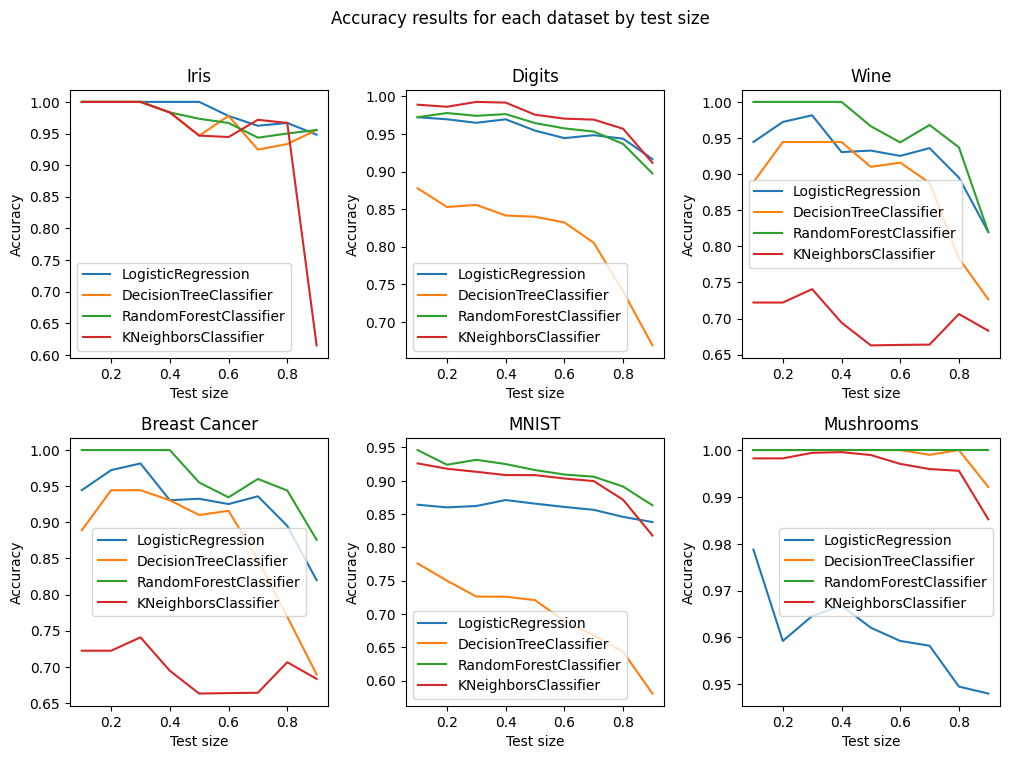

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Personalized Parameters
fig_columns = 3
size_width = 4
size_height = 4

# Personalized Models
models = [
    ("LogisticRegression", LogisticRegression()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("KNeighborsClassifier", KNeighborsClassifier())
]

# Datasets
iris = datasets.load_iris()
X_iris = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y_iris = pd.Series(iris['target']).map({i:label for i, label in enumerate(iris['target_names'])})

digits = datasets.load_digits()
X_digits = pd.DataFrame(digits['data'], columns=digits['feature_names'])
y_digits = pd.Series(digits['target']).map({i:label for i, label in enumerate(digits['target_names'])})

wine = datasets.load_wine()
X_wine = pd.DataFrame(wine['data'], columns=wine['feature_names'])
y_wine = pd.Series(wine['target']).map({i:label for i, label in enumerate(wine['target_names'])})

breast_cancer = datasets.load_wine()
X_breast_cancer = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
y_breast_cancer = pd.Series(breast_cancer['target']).map({i:label for i, label in enumerate(breast_cancer['target_names'])})

mnist = datasets.fetch_openml('mnist_784', version=1)
X_mnist = pd.DataFrame(mnist['data'], columns=mnist['feature_names'])
y_mnist = pd.Series(mnist['target'])
X_mnist, y_mnist = reduce_rows(X_mnist, y_mnist, data_size=5000)

mushrooms = datasets.fetch_openml('mushroom', version=1)
X_mushrooms = pd.DataFrame(mushrooms['data'], columns=mushrooms['feature_names'])
y_mushrooms = pd.Series(mushrooms['target'])
X_mushrooms, y_mushrooms = drop_na_rows(X_mushrooms, y_mushrooms)
X_mushrooms = label_encode_X(X_mushrooms)

# Type : List [ (X, y, name) ]
data_list = [
    (X_iris, y_iris, "Iris"),
    (X_digits, y_digits, "Digits"),
    (X_wine, y_wine, "Wine"),
    (X_breast_cancer, y_breast_cancer, "Breast Cancer"),
    (X_mnist, y_mnist, "MNIST"),
    (X_mushrooms, y_mushrooms, "Mushrooms")
]

# Plots
title = "Accuracy results for each dataset by test size"
models_metrics_plot2(data_list, models, fig_columns=fig_columns, size_width=size_width, size_height=size_height, title=title)

# Temps d'exécution : 1m

In [46]:
# Personalized Models
models = [
    ("LogisticRegression", LogisticRegression()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("KNeighborsClassifier", KNeighborsClassifier())
]

# Datasets
iris = datasets.load_iris()
X_iris = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y_iris = pd.Series(iris['target']).map({i:label for i, label in enumerate(iris['target_names'])})

digits = datasets.load_digits()
X_digits = pd.DataFrame(digits['data'], columns=digits['feature_names'])
y_digits = pd.Series(digits['target']).map({i:label for i, label in enumerate(digits['target_names'])})

wine = datasets.load_wine()
X_wine = pd.DataFrame(wine['data'], columns=wine['feature_names'])
y_wine = pd.Series(wine['target']).map({i:label for i, label in enumerate(wine['target_names'])})

breast_cancer = datasets.load_wine()
X_breast_cancer = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
y_breast_cancer = pd.Series(breast_cancer['target']).map({i:label for i, label in enumerate(breast_cancer['target_names'])})

mnist = datasets.fetch_openml('mnist_784', version=1)
X_mnist = pd.DataFrame(mnist['data'], columns=mnist['feature_names'])
y_mnist = pd.Series(mnist['target'])
X_mnist, y_mnist = reduce_rows(X_mnist, y_mnist, data_size=5000)

mushrooms = datasets.fetch_openml('mushroom', version=1)
X_mushrooms = pd.DataFrame(mushrooms['data'], columns=mushrooms['feature_names'])
y_mushrooms = pd.Series(mushrooms['target'])
X_mushrooms, y_mushrooms = drop_na_rows(X_mushrooms, y_mushrooms)
X_mushrooms = label_encode_X(X_mushrooms)

# Type : List [ (X, y, name) ]
data_list = [
    (X_iris, y_iris, "Iris"),
    (X_digits, y_digits, "Digits"),
    (X_wine, y_wine, "Wine"),
    (X_breast_cancer, y_breast_cancer, "Breast Cancer"),
    (X_mnist, y_mnist, "MNIST"),
    (X_mushrooms, y_mushrooms, "Mushrooms")
]

# Res list
table_acc_results = []

for model_name, model in models :
    # print(model_name)
    acc_results = []
    for X, y, data_name in data_list :
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_results.append(round(metrics.accuracy_score(y_test, y_pred), 2))
        # print(metrics.accuracy_score(y_test, y_pred))
    table_acc_results.append(acc_results)

table_acc_results = [[row[i] for row in table_acc_results] for i in range(len(table_acc_results[0]))]
print(table_acc_results)

# Create table
df_table_acc_results = pd.DataFrame(table_acc_results, columns=[model_name for model_name, _ in models])
df_table_acc_results.index = [data_name for _, _, data_name in data_list]
df_table_acc_results

# Temps d'exécution : 20s

c:\Users\sunse\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sunse\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

[[1.0, 1.0, 1.0, 1.0], [0.97, 0.85, 0.97, 0.99], [0.97, 0.94, 1.0, 0.72], [0.97, 0.94, 1.0, 0.72], [0.88, 0.77, 0.93, 0.93], [0.96, 1.0, 1.0, 1.0]]


,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier
Iris,1.00,1.00,1.00,1.00
Digits,0.97,0.85,0.97,0.99
Wine,0.97,0.94,1.00,0.72
Breast Cancer,0.97,0.94,1.00,0.72
MNIST,0.88,0.77,0.93,0.93
Mushrooms,0.96,1.00,1.00,1.00


### 3. Do the same with encoding - decoding by hand

In [18]:
list_q = df_row_to_question(X_test, iris['feature_names'], subject="iris type")

for model_name, model in models :
    model.fit(X_train, y_train)
    print("---------------")
    print(model_name)
    for q, real_label in zip(list_q, y_test) :
        a = traitement_question(model, q)
        label = re.findall(r'\b\w+\b$', a)[0]
        print("\tRéponse -->", a)
        print("\tLabel predicted =", label, ", Real label =", real_label)

---------------
LogisticRegression
	Réponse --> When we have sepal length (cm)=6.1, sepal width (cm)=2.8, petal length (cm)=4.7, petal width (cm)=1.2, the iris type is versicolor
	Label predicted = versicolor , Real label = versicolor
	Réponse --> When we have sepal length (cm)=5.7, sepal width (cm)=3.8, petal length (cm)=1.7, petal width (cm)=0.3, the iris type is setosa
	Label predicted = setosa , Real label = setosa
	Réponse --> When we have sepal length (cm)=7.7, sepal width (cm)=2.6, petal length (cm)=6.9, petal width (cm)=2.3, the iris type is virginica
	Label predicted = virginica , Real label = virginica
	Réponse --> When we have sepal length (cm)=6.0, sepal width (cm)=2.9, petal length (cm)=4.5, petal width (cm)=1.5, the iris type is versicolor
	Label predicted = versicolor , Real label = versicolor
	Réponse --> When we have sepal length (cm)=6.8, sepal width (cm)=2.8, petal length (cm)=4.8, petal width (cm)=1.4, the iris type is versicolor
	Label predicted = versicolor , Real

	Réponse --> When we have sepal length (cm)=6.7, sepal width (cm)=3.0, petal length (cm)=5.2, petal width (cm)=2.3, the iris type is virginica
	Label predicted = virginica , Real label = virginica
	Réponse --> When we have sepal length (cm)=6.7, sepal width (cm)=2.5, petal length (cm)=5.8, petal width (cm)=1.8, the iris type is virginica
	Label predicted = virginica , Real label = virginica
	Réponse --> When we have sepal length (cm)=6.8, sepal width (cm)=3.2, petal length (cm)=5.9, petal width (cm)=2.3, the iris type is virginica
	Label predicted = virginica , Real label = virginica
	Réponse --> When we have sepal length (cm)=4.8, sepal width (cm)=3.0, petal length (cm)=1.4, petal width (cm)=0.3, the iris type is setosa
	Label predicted = setosa , Real label = setosa
	Réponse --> When we have sepal length (cm)=4.8, sepal width (cm)=3.1, petal length (cm)=1.6, petal width (cm)=0.2, the iris type is setosa
	Label predicted = setosa , Real label = setosa
---------------
RandomForestClass